# Homework 6

In this homework, you'll review some linear algebra, and practice using `sklearn` and `scipy.optimize` to solve several variations of linear models.  You'll also use Pandas and Scikit learn for a simple machine learning task on a UCI data set.

In [3]:
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.linalg as la
import pandas as pd
import sklearn
from matplotlib import style
style.use("dark_background")

## Linear Models

A standard problem in statistics to solve the multivariate linear regression problem.
\begin{equation}
y = X * \beta + \epsilon
\end{equation}
The above notation is standard in statistics, but we'll use Householder notation by replacing $\beta$ with `b`
```
y = X * b + eps
```
`X` is known as the [design matrix](https://en.wikipedia.org/wiki/Design_matrix), and consists of `n` rows of observations, each of which has `p` features.  `y` is a vector of `n` responses.  `b` is an unknown vector of `p` coefficients which we would like to find.  `eps` (epsilon) is a vector of length `n` with random noise, typically i.i.d. normally distributed with variance `sig` (sigma).

In numpy notation, we could express this as
```python
y[i] = np.dot(X[i], b) + sig * np.random.randn()
```

We want to determine `b`, so that when me make a new observation `X[n]` we can predict the response `y[n]`.  Our goal is to minimize the mean square error

$$
\begin{equation}
\mathop{\mathsf{minimize}}_b \mathbb{E}((X[n]*b - y[n])^2)
\end{equation}
$$

The solution to this is the solution to the least squares problem
$$
\begin{equation}
\mathop{\mathsf{minimize}}_b \frac{1}{n} \|X*b - y\|_2^2
\end{equation}
$$

Where $n$ is the number of rows in $X$.  We'll let the solution to the problem be denoted $\hat{b}$, or `bhat`.

## Problem 0 - Linear Regression (30 points)

There are a variety of ways to solve the above problem.  We'll assume that $n > p$, meaning there are more observations than features.

### Generating Data

Write a function `gen_lstsq(n, p, sig=0.1)` which will generate a linear least squares problem (return `X`, `y`, and `b` as described above).  `b` is the "ground truth" coefficients that we are looking for.  You can generate the matrix `X` using `np.random.randn`, and generate `b` using `np.random.randn` as well.


In [33]:
## Your code here
def gen_lstsq(n, p, sig = 0.1):
    """
    Inputs dimension of the design matrix X

    Returns design matrix, true beta and response y
    """
    X = np.random.randn(n,p)
    b = np.random.randn(p)
    y = X@b + sig * np.random.randn(n)
    return [X,b,y]

### QR factorization

If we form a QR factorization $X = QR$, we can find $\hat{b} = R^{-1} Q^T y$.

Write a function `solve_lstsq_qr(X, y)` which estimates `b` using the QR factorization as above.

In [5]:
## Your code here
def solve_lstsq_qr(X, y):
    """
    Inputs a design matrix X and responsive value y

    Returns estimate for beta using qr decomposition
    """
    [Q,R] = la.qr(X, mode = 'economic')
    b_hat = la.solve(R, Q.T @ y)
    return b_hat

### Normal Equations

Often, this is the way statistics textbooks solve the problem: $\hat{b} = (X^T X)^{-1} X^T y$.  This is based on the normal equation $X^T X \hat{b} = X^T y$.

Write a function `solve_lstsq_normal(X, y)` which estimates `b` using the normal equations above.  You probably don't want to form the inverse - use an LU or Cholesky factorization instead.

In [6]:
## Your code here
def solve_lstsq_normal(X, y):
    """
    Inputs a design matrix X and responsive value y

    Returns estimate for beta using normal equation
    """
    R = la.cholesky(X.T @ X)
    z = la.solve_triangular(R.T, X.T @ y, lower = True)
    b_hat = la.solve_triangular(R, z)
    return b_hat

### Check Your Work

Generate a few random problems to test that `solve_lstsq_qr` and `solve_lstsq_normal` give the same prediction $\hat{b}$ (measure $\|\hat{b}_{qr} - \hat{b}_{normal}\|_2$ and check it is smaller than `1e-4`).  Use $n > p$.  Check against `solve_lstsq` in numpy or scipy as well.

In [7]:
## Your code here
import scipy
[X,b,y] = gen_lstsq(1000,100)
print(la.norm(solve_lstsq_qr(X,y) - solve_lstsq_normal(X,y)) < 1e-4)
print(la.norm(solve_lstsq_qr(X,y) - scipy.linalg.lstsq(X,y)[0]) < 1e-4)
print(la.norm(solve_lstsq_normal(X,y) - scipy.linalg.lstsq(X,y)[0]) < 1e-4)


True
True
True


### Estimate the Mean Squared Error

Write a function `mse` which estimates the mean squared error (MSE) $\mathbb{E}[\|X * \hat{b} - y\|_2^2]$.

The function should have the call signature `mse(b, bhat, N=100, sig=0.1)`  You can generate `X` to be `N x p` using `np.random.randn`, and set `y = X * b + sig * np.random.randn(p)` (use the same value of `sig` that you use when generating the data).  You can then estimate the MSE by computing $\frac{1}{N}\|X * \hat{b} - y\|_2^2$

Create a plot of the MSE vs the noise parameter `sig` (use the same value of `sig` when generating data and computing the MSE).  Put `sig` on a logartihmic axis ranging from `1e-4` to `10`.  Use `n=100`, `p=50` when generating data, and `N=100` when computing the MSE.  Put your plot on log-log axes.  Give it a title and axis labels.

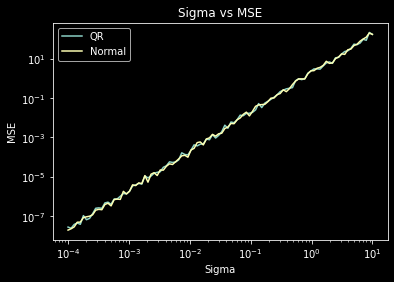

In [8]:
## Your code here
def mse(b, bhat, N = 100, sig = 0.1):
    p = len(b)
    X = np.random.randn(N,p)
    y = X @ b + sig * np.random.randn(N)
    return (1/N) * la.norm(X @ bhat - y)**2

sig_list = np.logspace(np.log10(1e-4), np.log10(10), 100)
mse_list_qr = []
mse_list_normal = []

for i in range(len(sig_list)):
    [X,b,y] = gen_lstsq(100,50,sig_list[i])
    bhat_qr = solve_lstsq_qr(X,y)
    bhat_normal = solve_lstsq_normal(X,y)
    mse_list_qr.append(mse(b,bhat_qr,sig = sig_list[i]))
    mse_list_normal.append(mse(b,bhat_normal,sig = sig_list[i]))

plt.loglog(sig_list, mse_list_qr, label = 'QR')
plt.loglog(sig_list, mse_list_normal, label = 'Normal')
plt.title("Sigma vs MSE")
plt.xlabel("Sigma")
plt.ylabel("MSE")
plt.legend()
plt.show()

### Discussion 1

Which of `solve_lstsq_qr` and `solve_lstsq_normal` is faster?  Give a justification for your answer (e.g. in terms of what you know about time to compute matrix multiplication and factorizations).

In [9]:
## Your code here
"""
We should expect that normal is faster than qr. If we do some research we will soon
find out that cholesky decomposition is faster than qr decomposition. Even though in cholesky based
solver we have to solve two systems of linear equations, but the advantages in computing time of decomposition
will compensate that disadvantage and the overall runtime will surpass that of qr decomposition based solver.

We can do an example to illustrate that below
"""
[X,b,y] = gen_lstsq(5000,1000)
start = time.time()
bhat = solve_lstsq_normal(X, y)
end = time.time()
print(f"Time for normal: {{}}".format(end - start))

start = time.time()
bhat = solve_lstsq_qr(X, y)
end = time.time()
print(f"Time for qr: {{}}".format(end - start))

Time for normal: 0.04881095886230469
Time for qr: 0.4106898307800293


---

_your discussion here_

### Optimization

Solve the minimization problem
$$
\begin{equation}
\mathop{\mathsf{minimize}}_b \frac{1}{n}\|X*b - y\|_2^2
\end{equation}
$$

using `scipy.optimize.minimize`.  Wrap this in a function `solve_lstsq_opt(X, y)`.  Note that you can define the objective function inside `solve_lstsq_opt`

**Jacobian**: you should implement the Jacobian of the objective function to use in the optimization problem.  Here's a derivation:  We'd like to minimize the objective function
$$
\begin{equation}
n f(b) = \|X*b - y\|_2^2 = (Xb - y)^T (Xb - y) = b^T X^T X b - 2 y^T X b + y^T y
\end{equation}
$$

We might write the above expression as
$$
\begin{equation}
n f(b) \sum_{i,j} b_i (X^T X)_{i,j} b_j - 2\sum_{j,i} y_i X_{i,j} b_j + y^T y
\end{equation}
$$

We can take a derivative with respect to $b_j$
$$
\begin{equation}
n \frac{\partial f}{\partial b_j} = \sum_{i\ne j} b_i (X^T X)_{i,j} + \sum_{i\ne j} (X^T X)_{j,i} b_i + 2 (X^T X)_{j,j} b_j  - 2\sum_{i} y_i X_{i,j}
\end{equation}
$$

Putting this in matrix form, we obtain
$$
\begin{equation}
J_f(b) =  \frac{1}{n}\big( b^T (X^T X) + b^T (X^T X)^T - 2y^T X\big) = \frac{2}{n} b^T (X^T X) -\frac{2}{n}y^T X
\end{equation}
$$

So we can write $J_f(b) = \frac{2}{n} b^T (X^T X) -\frac{2}{n} y^T X$

In [10]:
## Your code here
def solve_lstsq_opt(X, y, method = 'BFGS'):
    """
    Inputs design matrix X and responses y

    Outputs estimate of beta using optimization function
    """
    n = X.shape[0]
    def fun(b):
        return (1/X.shape[0]) * la.norm(X @ b - y)**2

    def jac(b):
        return (2/n)*b.T@X.T@X - (2/n)*y.T@X

    bhat = scipy.optimize.minimize(fun, x0 = np.random.randn(X.shape[1]), method = method, jac = jac)
    return bhat

#### Check Your Work

Generate a few random problems to test that `solve_lstsq_opt` agrees with `solve_lstsq_qr` and `solve_lstsq_normal` in part A.  Use the same tolerance for checking.

In [11]:
[X,b,y] = gen_lstsq(1000,100)
# Comparing with normal
print(la.norm(solve_lstsq_opt(X,y).x - solve_lstsq_normal(X,y)) < 1e-4)
# Comparing with lstsq
print(la.norm(solve_lstsq_opt(X,y).x - scipy.linalg.lstsq(X,y)[0]) < 1e-4)
# Comparing with qr
print(la.norm(solve_lstsq_opt(X,y).x - solve_lstsq_qr(X,y)) < 1e-4)

True
True
True


### Discussion 2

How fast is `solve_lstsq_opt` compared to the functions you wrote in part A?  Give some justification for what you see.

In [42]:
## Your code here

"""
The time it takes for optimization function to find its solution depends highly on what
method we choose. Here we illustrate if we use the default method, which is BFGS, and if 
we use CG. We will see that if we use BFGS, then optimization based solver is slower than
qr decomposition based solver, but faster if we use CG.
"""
time_normal = []
time_qr = []
time_cg = []
time_bfgs = []

for i in range(100):
    [X,b,y] = gen_lstsq(5000,1000)
    start = time.time()
    bhat = solve_lstsq_normal(X, y)
    end = time.time()
    time_normal.append(end - start)

    start = time.time()
    bhat = solve_lstsq_qr(X, y)
    end = time.time()
    time_qr.append(end - start)

    start = time.time()
    bhat = solve_lstsq_opt(X, y, method = 'CG')
    end = time.time()
    time_cg.append(end - start)

    start = time.time()
    bhat = solve_lstsq_opt(X, y, method = 'BFGS')
    end = time.time()
    time_bfgs.append(end - start)

print(f"Time for normal: {{}}".format(np.mean(time_normal)))
print(f"Time for qr: {{}}".format(np.mean(time_qr)))
print(f"Time for opt with method = 'CG': {{}}".format(np.mean(time_cg)))
print(f"Time for opt with method = 'BFGS': {{}}".format(np.mean(time_bfgs)))

Time for normal: 0.047216594219207764
Time for qr: 0.486082227230072
Time for opt with method = 'CG': 0.17162737607955933
Time for opt with method = 'BFGS': 0.8749001216888428


---

_your discussion - you can add more code/markdown cells_

### Scikit Learn

Use [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) to solve the linear regression problem. You can get the vector `bhat` from `model.coef_`

Make a plot for the MSE like you did above using `LinearRegression` instead of a `solve_lstsq` function.  Set the keyword `fit_intercept=False`.

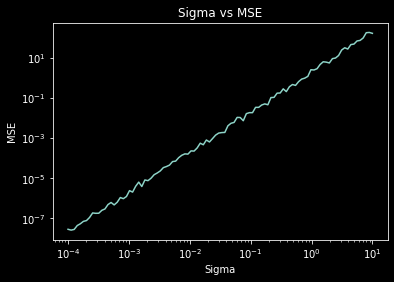

In [40]:
## Your code here
def mse(b, bhat, N = 100, sig = 0.1):
    """
    Inputs true beta b, estimator bhat, number of samples N and sigma

    Outputs MSE of that bhat
    """
    p = len(b)
    X = np.random.randn(N,p)
    y = X @ b + sig * np.random.randn(N)
    return (1/N) * la.norm(X @ bhat - y)**2

sig_list = np.logspace(np.log10(1e-4), np.log10(10), 100)
mse_list = []

for i in range(len(sig_list)):
    [X,b,y] = gen_lstsq(100,50,sig_list[i])
    bhat = sklearn.linear_model.LinearRegression(fit_intercept = False).fit(X,y).coef_
    mse_list.append(mse(b,bhat,sig = sig_list[i]))

plt.loglog(sig_list, mse_list)
plt.title("Sigma vs MSE")
plt.xlabel("Sigma")
plt.ylabel("MSE")
plt.show()

## Problem 1 - Ridge Regression (15 points)

We'll now turn to the problem of what to do when `n < p` (there are fewer observations than features).  In this case we can solve $X * b = y$ exactly, but there are many possible values of $b$ which can satisfy the equation.

The normal equations are singular, and the $R$ term of the QR factorization is not invertible in this case.  We need to do something else.

Ridge regression seeks to solve the following optimization problem:
$$
\begin{equation}
\mathop{\mathsf{minimize}}_b \frac{1}{n}\|X*b - y\|_2^2 + \lambda \|b\|_2^2
\end{equation}
$$
$\lambda$ is a parameter you can choose to "regularize" the problem which you can choose.

### Optimization

Use `scipy.optimize.minimize` to minimize the above optimization problem.  Wrap this in a function `solve_ridge_opt(X, y, lam=0.1)` (`lam` should be provided as a keyword argument for the variable $\lambda$).

What is the Jacobian for the objective function for the minimization problem?  Incorporate this into your optimization problem.  Hint: differentiation is linear, so you just need to add a term to the Jacobian in Problem 0 based on the Jacobian of
$$
\begin{equation}
\lambda \|b\|_2^2 = \lambda b^T b = \lambda \sum_i b_i^2
\end{equation}
$$
---

_put the expression for the Jacobian here_

In [29]:
## Your code here
"""
We can see that the partial derivative of \lambda * sum(b_i**2) wrt b_i is 2 * lambda * b_i, which
put into matrix form is 2*lambda*b, so we have
jacobian = (2/n)*b.T@X.T@X - (2/n)*y.T@X + 2*lambda*b
"""
def solve_ridge_opt(X, y, lam = 0.1, method = 'BFGS'):
    """
    Inputs design matrix X and responses y

    Outputs estimate of beta using ridge regression(optimize version)
    """
    n = X.shape[0]
    def fun(b):
        return (1/X.shape[0]) * la.norm(X @ b - y)**2 + lam * la.norm(b)**2

    def jac(b):
        return (2/n)*b.T@X.T@X - (2/n)*y.T@X + 2*lam*b

    bhat = scipy.optimize.minimize(fun, x0 = np.random.randn(X.shape[1]), method = method, jac = jac)
    return bhat

### Compute the MSE

Set `n = 50`, `p=100`, and `sig=0.1`.  Make a plot that displays the MSE of `bhat` computed using `solve_ridge_opt` as `lam` varies between `1e-4` and `1e2`.  Use a `semilogx` plot.

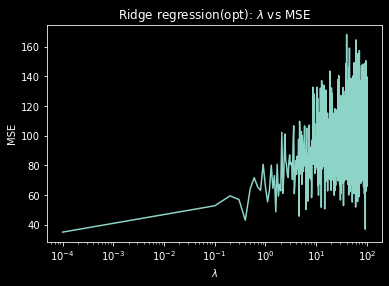

In [56]:
## Your code here
[X,b,y] = gen_lstsq(50,100,0.1)
lam = np.linspace(1e-4, 1e2, 1000)
mse_list = []

for i in range(len(lam)):
    bhat = solve_ridge_opt(X, y, lam = lam[i], method = 'CG').x
    mse_list.append(mse(b, bhat, N = 50))

plt.semilogx(lam, mse_list)
plt.xlabel("$\lambda$")
plt.ylabel("MSE")
plt.title("Ridge regression(opt): $\lambda$ vs MSE")
plt.show()

### Scikit Learn

Use [`sklearn.linear_model.Ridge`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) to solve the Ridge regression problem (note that this uses the keyword `alpha` where we have used `lam`). You can get the vector `bhat` from `model.coef_`

Make a plot for the MSE like you did above using `Ridge` instead of your `solve_ridge_opt` function.  In addition to the keyword `alpha`, set `fit_intercept=False`

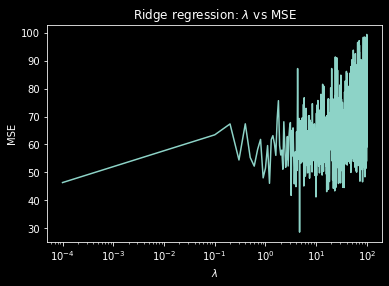

In [59]:
## Your code here
mse_list = []

for i in range(len(lam)):
    bhat = sklearn.linear_model.Ridge(alpha = lam[i], fit_intercept = False).fit(X,y).coef_
    mse_list.append(mse(b,bhat))

plt.semilogx(lam, mse_list)
plt.xlabel("$\lambda$")
plt.ylabel("MSE")
plt.title("Ridge regression: $\lambda$ vs MSE")
plt.show()

In [ ]:
"""
Note that we are observing more or less the same trend, but one minor
difference is that the MSE for ridge() from sklearn is lower when lambda
gets larger. Another way to see it is that the scale for MSE in latter plot
is range [30,100] while the former one is in [40,160].
"""

## Problem 2 - Lasso (15 points)

The Lasso is L1-regularized regression.  This is often used when `p > n`, and when the parameter vector `b` is assumed to be sparse, meaning that it has few non-zero entries.

The minimization problem is
$$
\begin{equation}
\mathop{\mathsf{minimize}}_b \frac{1}{n} \|X * b - y\|_2^2 + \lambda \|b\|_1
\end{equation}
$$

Where again, $\lambda$ can be chosen.

### Generate Data

We need to modify our generation of data to produce sparse `b`.  Write a function `gen_lstsq_sparse(n, p, sig=0.1, k=10)`, which generates `X` and `y` in the same way as `gen_lstsq`, but now `b` is generated to be a vector of length `p` with `k` random entries set to 1, and all other entries set to 0. Hint: look at `np.random.choice` for generating `k` random integers without replacement.

In [64]:
## Your code here
def gen_lstsq_sparse(n, p, sig = 0.1, k = 10):
    """
    Inputs dimension of the design matrix X

    Returns design matrix, true beta(sparse) and response y
    """
    X = np.random.randn(n,p)
    b = np.zeros(p)
    ind = np.random.choice(n, size = k, replace = False)
    b[ind] = 1
    y = X@b + sig * np.random.randn(n)
    return [X,b,y]

### Optimization

Recall we want to find `bhat` to solve
$$
\begin{equation}
\mathop{\mathsf{minimize}}_b \frac{1}{n} \|X * b - y\|_2^2 + \lambda \|b\|_1
\end{equation}
$$

Use `scipy.optimize.minimize` to minimize the above optimization problem.  Wrap this in a function `solve_lasso_opt(X, y, lam=0.1)` (`lam` should be provided as a keyword argument for the variable $\lambda$).

What is the Jacobian for the objective function for the minimization problem?  Incorporate this into your optimization problem.  Hint: differentiation is linear, so you just need to add a term to the Jacobian in Problem 0 based on the Jacobian of
$$
\begin{equation}
\lambda \|b\|_1 = \lambda \sum_i |b_i|
\end{equation}
$$

If $b_i$ is zero, then take $\partial_i |b_i| = 0$ (this is in the [subgradient](https://en.wikipedia.org/wiki/Subderivative)). Hint 2: look at `np.sign` for implementation

---

_put the expression for the Jacobian here_

In [67]:
## Your code here
def solve_lasso_opt(X, y, lam = 0.1, method = 'BFGS'):
    """
    Inputs design matrix X and responses y

    Outputs estimate of beta using lasso(optimize version)
    """
    n = X.shape[0]
    def fun(b):
        return (1/n) * la.norm(X@b - y)**2 + lam * la.norm(b, ord = 1)

    def jac(b):
        return (2/n)*b.T@X.T@X - (2/n)*y.T@X + lam * np.sign(b)
    
    bhat = scipy.optimize.minimize(fun, x0 = np.random.randn(n), method = method, jac = jac)
    return bhat


### Compute the MSE

Set `n = 50`, `p=100`,`sig=0.1`, and `k=10` to generate a problem using `gen_lstsq_sparse`.  Make a plot that displays the MSE of `bhat` computed using `solve_lasso_opt` as `lam` varies between `1e-4` and `1e2`.  Use a `semilogx` plot.

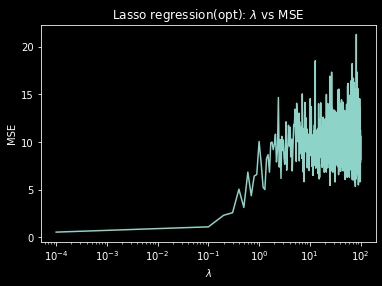

In [70]:
## Your code here
[X,b,y] = gen_lstsq_sparse(50,100)
lam = np.linspace(1e-4, 1e2, 1000)
mse_list = []

for i in range(len(lam)):
    bhat = solve_lasso_opt(X, y, lam = lam[i], method = 'CG').x
    mse_list.append(mse(b, bhat, N = 50))

plt.semilogx(lam, mse_list)
plt.xlabel("$\lambda$")
plt.ylabel("MSE")
plt.title("Lasso regression(opt): $\lambda$ vs MSE")
plt.show()

### Scikit Learn

Use [`sklearn.linear_model.Lasso`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso) to solve the Lasso regression problem (note that this uses the keyword `alpha` where we have used `lam`). You can get the vector `bhat` from `model.coef_`

Make a plot for the MSE like you did above using `Lasso` instead of your `solve_lasso_opt` function.  In addition to the keyword `alpha`, set `fit_intercept=False`

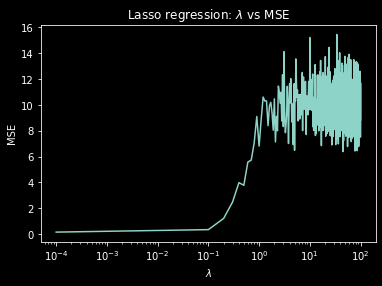

In [73]:
## Your code here
mse_list = []

for i in range(len(lam)):
    bhat = sklearn.linear_model.Lasso(alpha = lam[i], fit_intercept = False, max_iter = 10000).fit(X,y).coef_
    mse_list.append(mse(b,bhat))

plt.semilogx(lam, mse_list)
plt.xlabel("$\lambda$")
plt.ylabel("MSE")
plt.title("Lasso regression: $\lambda$ vs MSE")
plt.show()

In [ ]:
"""
We are more or less seeming the same thing, both MSE and shape of
the graph.
"""

## Problem 3 - Elastic Net (20 points)

Another option when `p > n` is the [Elastic Net]() which combines L1 and L2 regularization.
$$
\begin{equation}
\mathop{\mathsf{minimize}}_b \frac{1}{n} \|X * b - y\|_2^2 + \lambda_1 \|b\|_1 + \lambda_2 \|b\|_2^2
\end{equation}
$$
Where we get to choose $\lambda_1$ and $\lambda_2$.

You can find a function that does this in [`sklearn.linear_model.ElasticNet`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet).

In this problem, you'll write a class that emulates the behavior of a Scikit learn class. Use `scipy.optimize.minimize` to solve the optimization problem.


### Jacobian

Give an expression for the Jacobian for the optimization objective function.  You've already done all the hard work for this in problems 1 and 2

---

_put the Jacobian expression here_

$J_f(b) = \frac{2}{n} b^T (X^T X) -\frac{2}{n} y^T X + \lambda_1 * sign(b) + 2 * \lambda_2 * b$

### Write the Class

Define a Python Class `ElasticNet`.  When you initialize the class you should be able to provide keyword arguments `lam1` for $\lambda_1$ and `lam2` for $\lambda_2$.  Give each these keyword arguments a default value of `0.5`.

In addition to `__init__`, your class should provide two methods:
1. `fit(X, y)` - sets an attribute `bhat` which solves the optimization problem (use the parameters `lam1` and `lam2` provided in initialization).  Use `scipy.optimize.minimize`
2. `predict(X)` - predict values of `y` as `X @ bhat`

In [97]:
## Your code here
class ElasticNet:
    """
    Elastic Net class
    """
    def __init__(self, lam1 = 0.5, lam2 = 0.5):
        """
        Input lambda_1 and lambda_2
        """
        self.lam1 = lam1
        self.lam2 = lam2

    def fit(self, X, y, method = 'BFGS'):
        """
        Inputs X and y

        Returns estimated beta using elastic net via optimization
        """
        n = X.shape[0]
        p = X.shape[1]
        def fun(b):
            return (1/n) * la.norm(X@b - y)**2 + self.lam1 * la.norm(b, ord = 1) + self.lam2 * la.norm(b, ord = 2)**2

        def jac(b):
            return (2/n)*b.T@X.T@X - (2/n)*y.T@X + self.lam1 * np.sign(b) + self.lam2 * 2 * b
        
        bhat = scipy.optimize.minimize(fun, x0 = np.random.randn(p), method = method, jac = jac)
        self.bhat = bhat.x
        return(self.bhat)

    def predict(self,X):
        """
        Inputs X

        Returns prediction of y
        """
        self.y = X @ self.bhat


### Compute the MSE

Set `n=50`, `p=100`,`sig=0.1`, and `k=10` to generate a problem using `gen_lstsq_sparse`.  

Set `n=50`, `p=100`, and `sig=0.1` to generate a problem using `gen_lstsq`.

Make a plot that displays the MSE of the model computed using your `ElasticNet` class using `lam1=lam2` varying between `1e-4` and `1e2` for each of the generated problems (your plot should have 2 lines).  Give your plot a title, axis labels, and a legend.

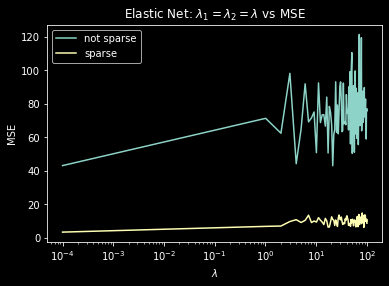

In [104]:
[X_s, b_s, y_s] = gen_lstsq_sparse(50,100)
[X, b, y] = gen_lstsq(50,100)

ElasticNet().fit(X_s, y_s)

lam = np.linspace(1e-4, 1e2, 100)
mse_normal = []
mse_sparse = []

for i in range(len(lam)):
    model = ElasticNet(lam1 = lam[i], lam2 = lam[i])
    mse_normal.append(mse(b, model.fit(X,y,method = 'CG'), N = 50))
    mse_sparse.append(mse(b_s, model.fit(X_s,y_s,method = 'CG'), N = 50))

plt.semilogx(lam, mse_normal, label = 'not sparse')
plt.semilogx(lam, mse_sparse, label = 'sparse')
plt.xlabel("$\lambda$")
plt.ylabel("MSE")
plt.title("Elastic Net: $\lambda_1 = \lambda_2 = \lambda$ vs MSE")
plt.legend()
plt.show()

## Problem 4 - Real Data (20 points)

In this problem you'll use the [Wine Quality Data Set](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/).  We'll focus on the red wines found in [`winequality-red.csv`](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv).  The goal is to train a machine learning model that will predict the wine quality from a variety of other features.

### Load the data set

Load the wines in `windquality-red.csv` into a Pandas data frame. Note that this file has column labels, which are interpreted in the data set documentation:

Input variables (based on physicochemical tests):
1. fixed acidity
2. volatile acidity
3. citric acid
4. residual sugar
5. chlorides
6. free sulfur dioxide
7. total sulfur dioxide
8. density
9. pH
10. sulphates
11. alcohol

Output variable (based on sensory data):

12. quality (score between 0 and 10)

Note that this file uses semi-colons `;` to delimit values.  You can use `delimiter=';'` as a keyword argument.

In [115]:
## Your code here
data = pd.read_csv("winequality-red.csv", delimiter = ';')

The first 11 columns will be features for the model (used in the design matrix `X`), and the last column (quality) is the quantity we're tyring to predict (the response `y`).

### Split the Data in to Training and Testing Sets

Split the data `X, y` into `X_train, y_train, X_test, y_test` using `sklearn`.  Use 70% of the data for training, and 30% of the data for testing.


In [127]:
## Your code here
import sklearn.model_selection as ms
X = data[["fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides", 
    "free sulfur dioxide", "total sulfur dioxide", "density", "pH", "sulphates", "alcohol"]]

y = data["quality"]

X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.3, shuffle=True)

### Train a Model and Measure Error

Use [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) to fit a linear regression model to your training data.

Use [`sklearn.metrics.mean_squared_error`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error) to compute the MSE on your test set.

In [134]:
## Your code here
model = sklearn.linear_model.LinearRegression()
model.fit(X_train, y_train)
mse = sklearn.metrics.mean_squared_error(y_test, model.predict(X_test))
print(f"MSE for Linear Regression is {{}}".format(mse))

MSE for Linear Regression is 0.3923702313734439
